In [1]:
# Import in this fashion only
# otherwise moviepy crashes

import matplotlib
matplotlib.use("TkAgg")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os

import pickle

In [3]:
from moviepy.editor import VideoFileClip

In [4]:
%matplotlib inline

In [5]:
# Import required methods

from cam_calibrate import CALIBRATION_IMAGES_FOLDER, PICKLE_NAME, get_calibration
from perspective_trans import get_perspectiveTransform
from colour_gradient import get_gradients
from undistort_image import get_undistorted_image
from lane_lines import get_lane_lines_window, get_lane_lines_using_prev_info, get_lane_line_pixels, get_curvature, draw

In [6]:
# Lists to store the last 'n'(default=10) values for fitted curve

left_fit_list = list()
right_fit_list = list()

In [7]:
# Set plot -> true if you want to see all the intermideate steps
# n -> number of frames on which average is to be done
#      since it is a 50 seconds video
#      with 1261 frames
#      1261/50 ~ 25 frames/sec
#      Thus averaging over 25 frames will provide stablity

def process_final(image, plot=False, n=25):
    # Gets the undistorted image from saved camera matrix
    undist = get_undistorted_image(image)
    
    # Returns gradients image
    grad = get_gradients(undist, plot=plot)[1]
    
    # returns wraped image and inversion matrix
    binary_warped, Minv = get_perspectiveTransform(grad, plot)
    
    # Check if this is the first frame
    # If yes, then we will search entire frame using windows
    if (len(left_fit_list) == 0) and (len(right_fit_list) == 0):
        ploty, left_fitx, right_fitx, left_fit, right_fit, window_img = get_lane_lines_window(binary_warped, plot)
        left_fit_list.append(left_fit)
        right_fit_list.append(right_fit)
    
    # Otherwise, we use data from previous frames and search in limited 
    # area that makes the process faster
    else :
        # Get values of y
        plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
        # Find average of last 'n' fits
        left_fit_avg = np.mean(left_fit_list, axis=0)
        right_fit_avg = np.mean(right_fit_list, axis=0)
    
        # calculate x values from 2nd degree polynomial
        left_fitx = left_fit_avg[0] * plot_y**2 + left_fit_avg[1] * plot_y + left_fit_avg[2]
        right_fitx = right_fit_avg[0] * plot_y**2 + right_fit_avg[1] * plot_y + right_fit_avg[2]

        # Get new polynomial using average data for the current frame
        left_fit_new, right_fit_new, ploty, prev_img = get_lane_lines_using_prev_info(binary_warped, left_fitx, right_fitx, left_fit_avg, right_fit_avg, plot)
        
        # Get pixel image info
        # pixel_img = get_lane_line_pixels(ploty, left_fitx, right_fitx)
    
        # If len of list becomes equal to n
        # drop the earliest frame
        assert(len(left_fit_list) == len(right_fit_list))
        if len(left_fit_list) == n:
            left_fit_list.pop(0)
            right_fit_list.pop(0)

        # append new data in the list
        left_fit_list.append(left_fit_new)
        right_fit_list.append(right_fit_new)

    # curvature of left and right lines and car position meters off track
    l, r, m = get_curvature(image, ploty, left_fitx, right_fitx)

    # Final image with lanes hilighted
    final_img = draw(ploty, left_fitx, right_fitx, binary_warped, Minv, undist, image)
    
    # Put Text on image frames
    cv2.putText(final_img, 'Left Curvature   : ' + str(l)[:6] + ' m',
                (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

    cv2.putText(final_img, 'Right Curvature  : ' + str(r)[:6] + ' m',
                (50, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

    cv2.putText(final_img, 'Off Center       : ' + str(m)[:6] + ' m',
                (50, 170), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

    return (final_img)

In [8]:
del left_fit_list[:]
del right_fit_list[:]

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:52<00:00,  4.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 59s, sys: 1min 23s, total: 6min 22s
Wall time: 4min 53s


In [ ]:
# Examples of Images processed

In [44]:
def pipeline(image, plot=False, s_thresh=(170,225), sx_thresh=(20,100)):
    if plot:
        plt.imshow(image)
        plt.show()
    undist = get_undistorted_image(image)
    grad = get_gradients(undist, plot=plot, s_thresh=s_thresh, sx_thresh=sx_thresh)[1]
    binary_warped, Minv = get_perspectiveTransform(grad, plot)

    ploty, left_fitx, right_fitx, left_fit, right_fit, window_img = get_lane_lines_window(binary_warped, plot)
    left_fitx, right_fitx, ploty, prev_img = get_lane_lines_using_prev_info(binary_warped, left_fitx, right_fitx, left_fit, right_fit, plot)
    # pixel_img = get_lane_line_pixels(ploty, left_fitx, right_fitx)
    l, r = get_curvature(ploty, left_fitx, right_fitx)
    final_img = draw(ploty, left_fitx, right_fitx, binary_warped, Minv, undist, image)

    return final_img

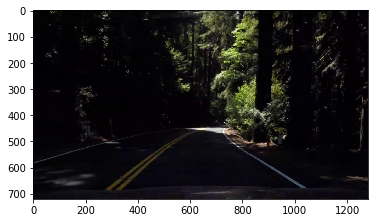

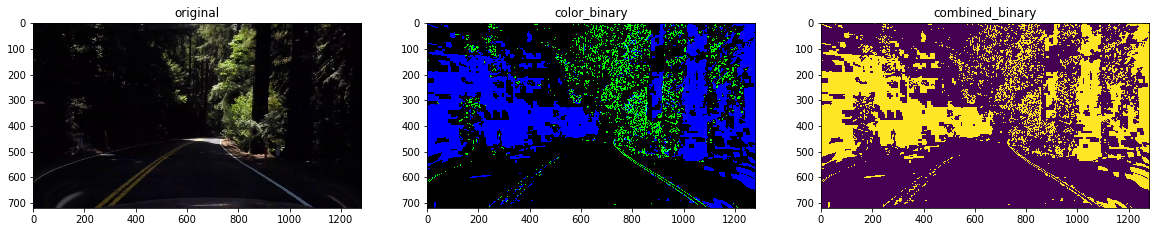

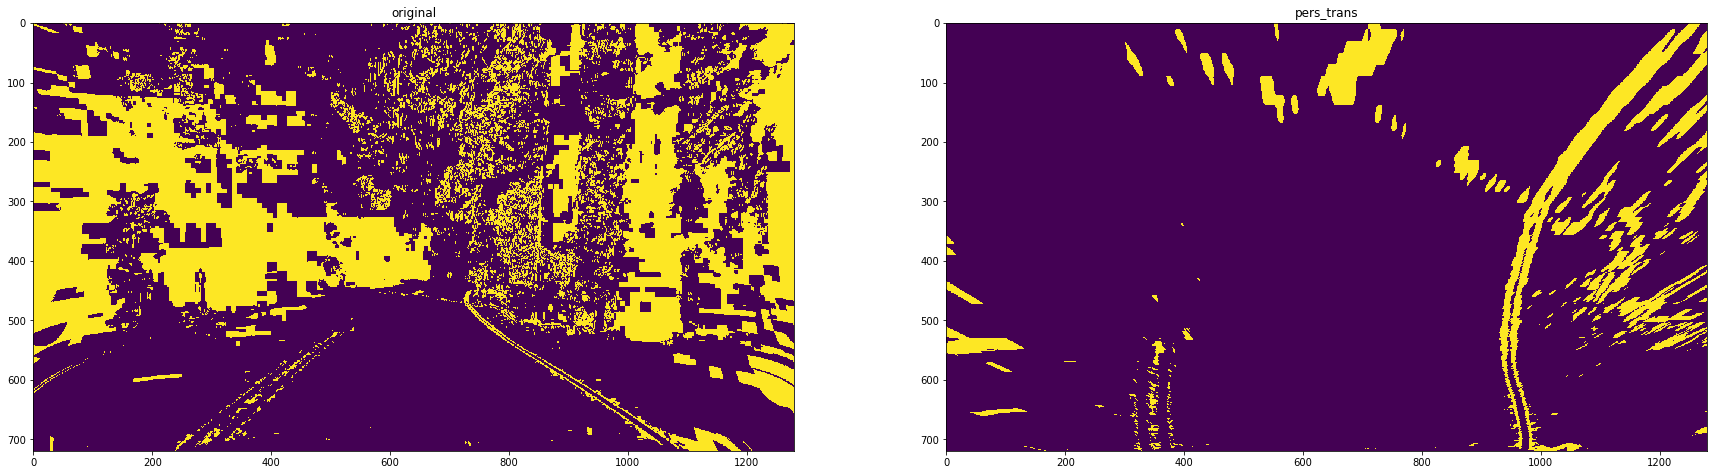

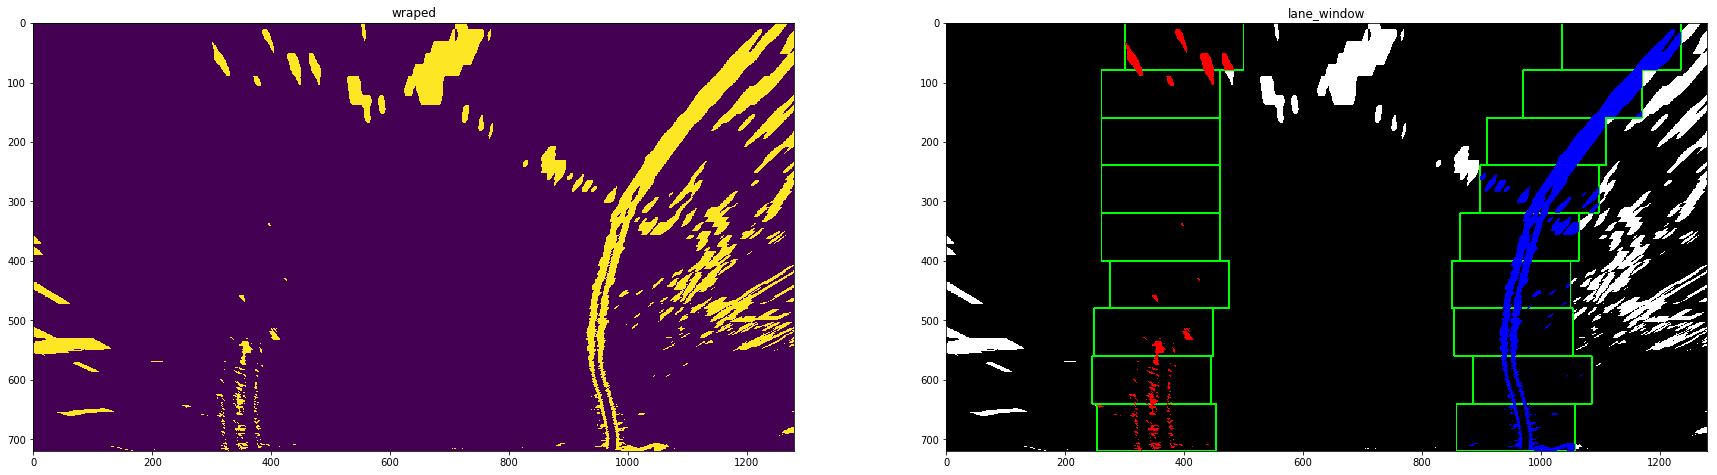

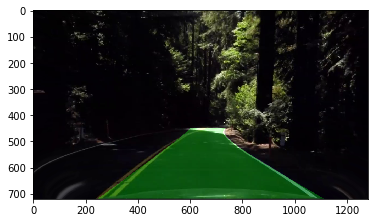

In [8]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_23.jpg'), plot=True))

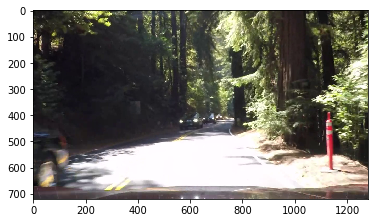

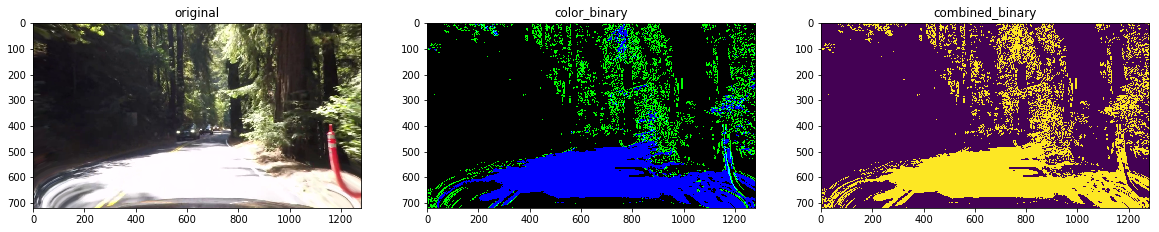

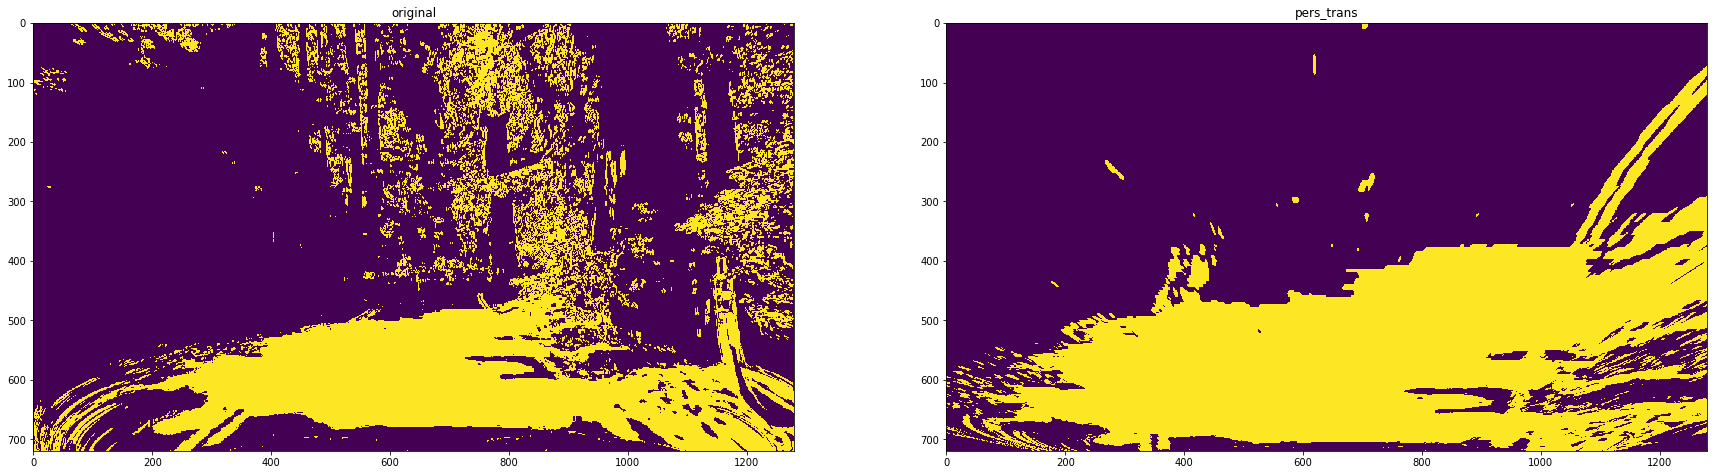

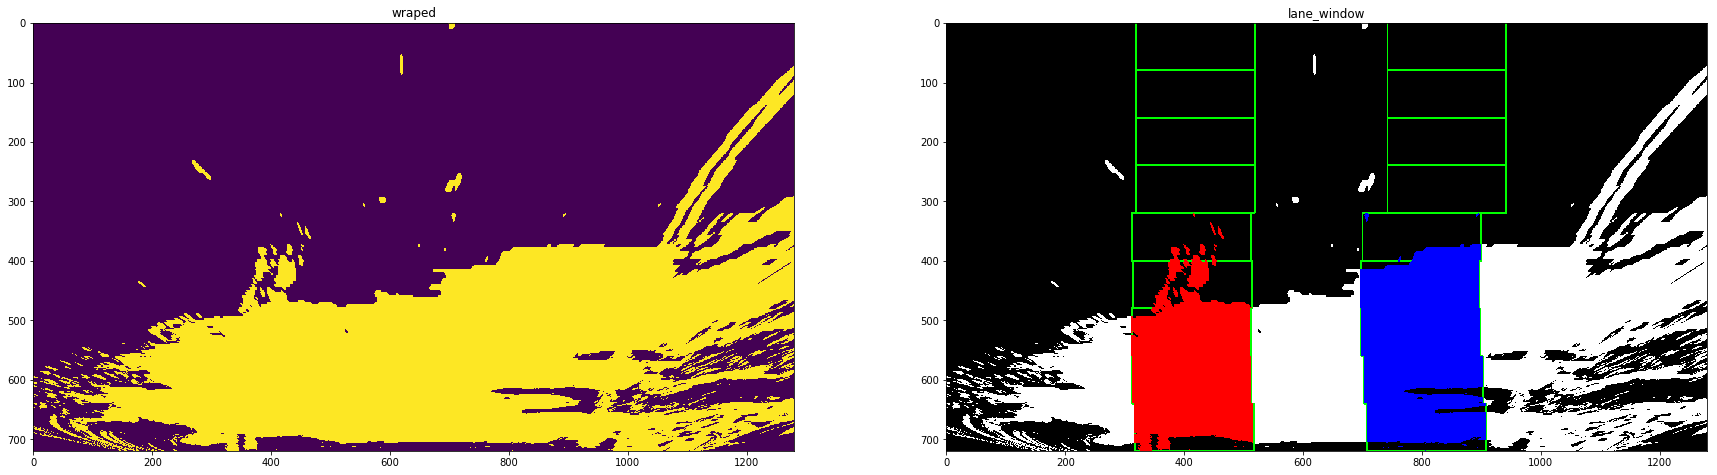

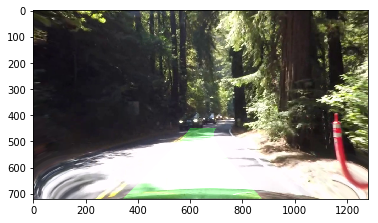

In [9]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_25.jpg'), plot=True))

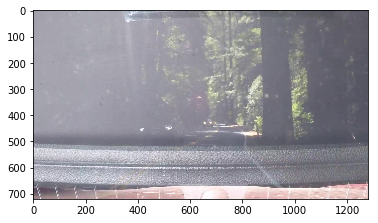

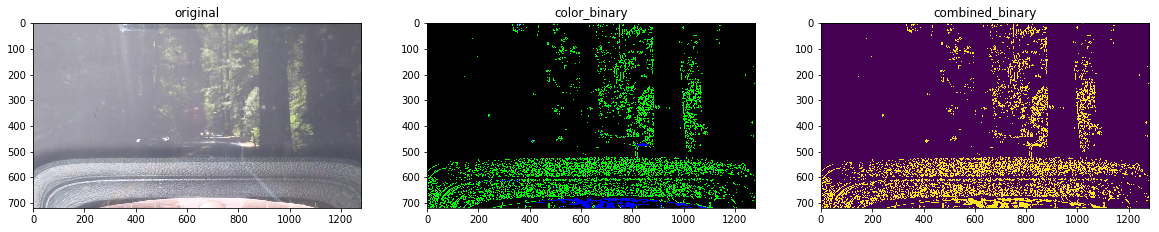

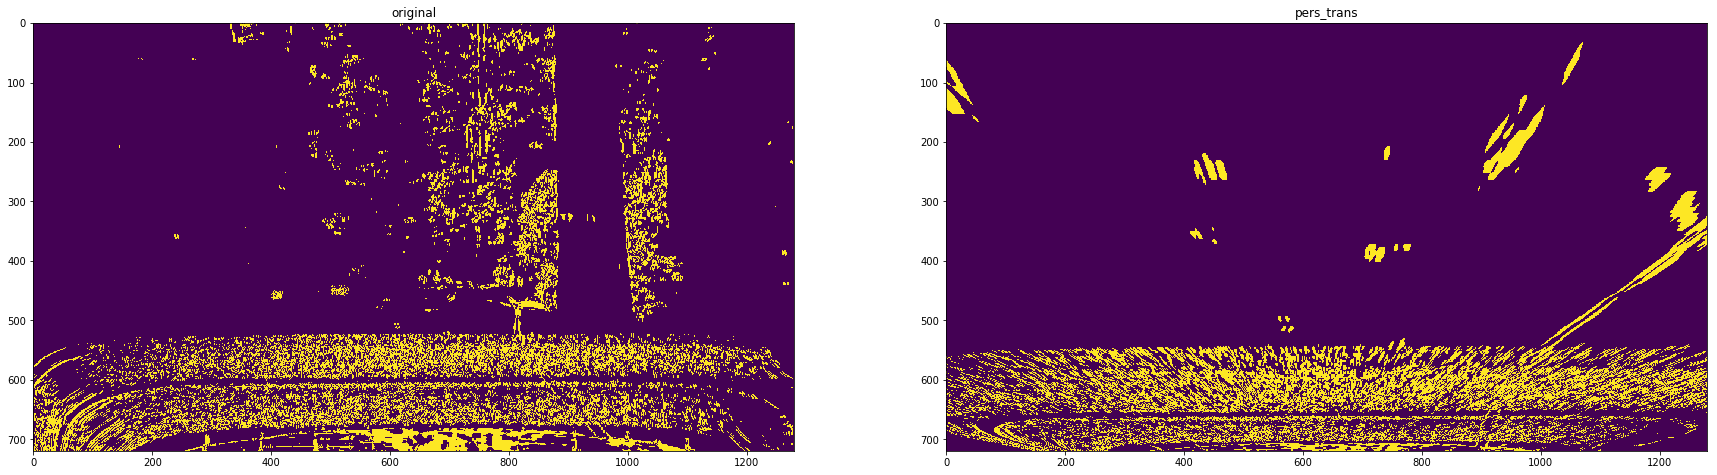

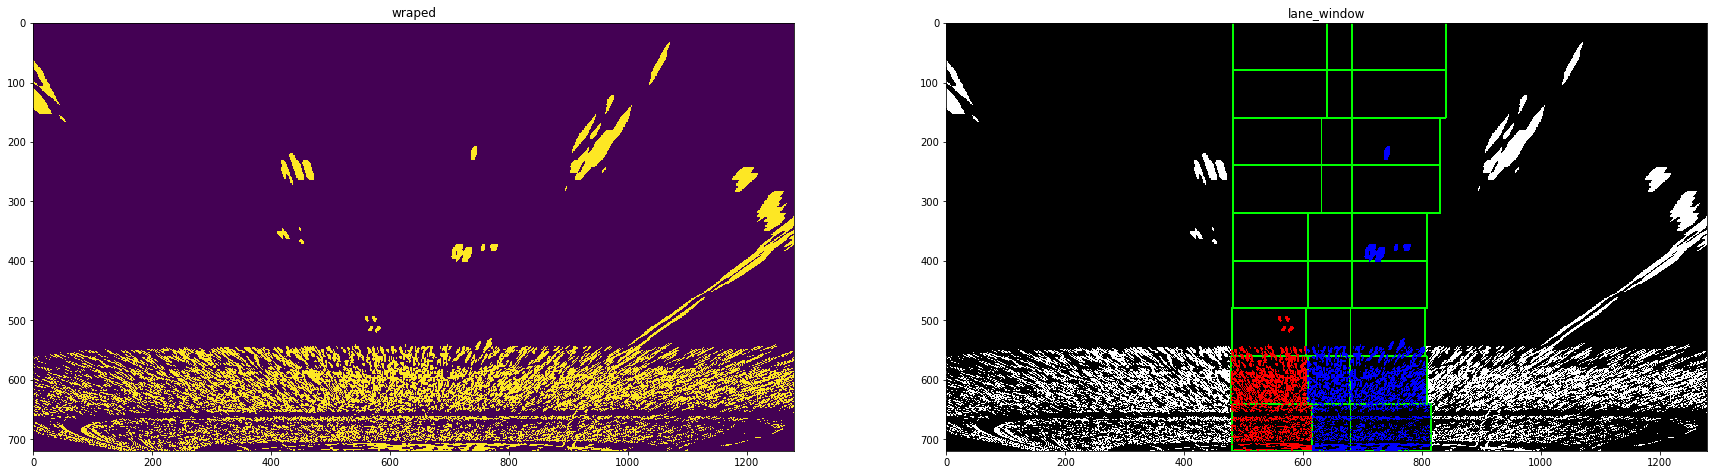

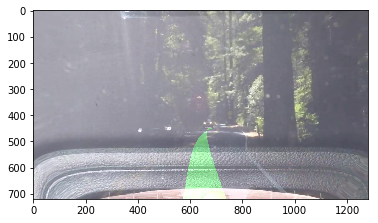

In [10]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_26.jpg'), plot=True))

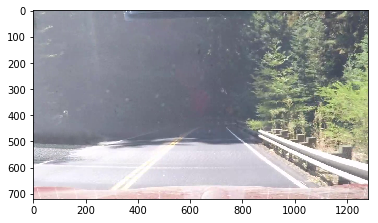

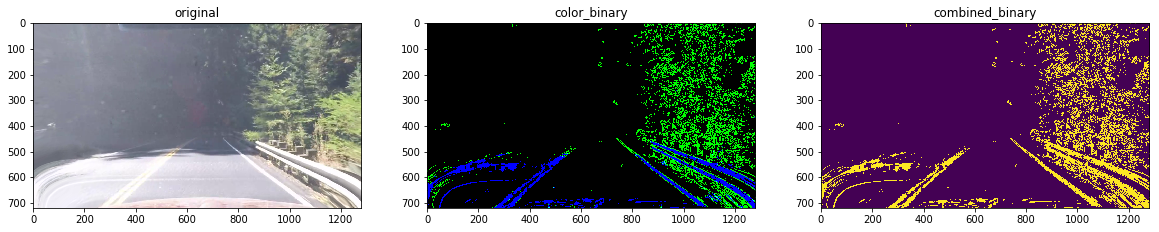

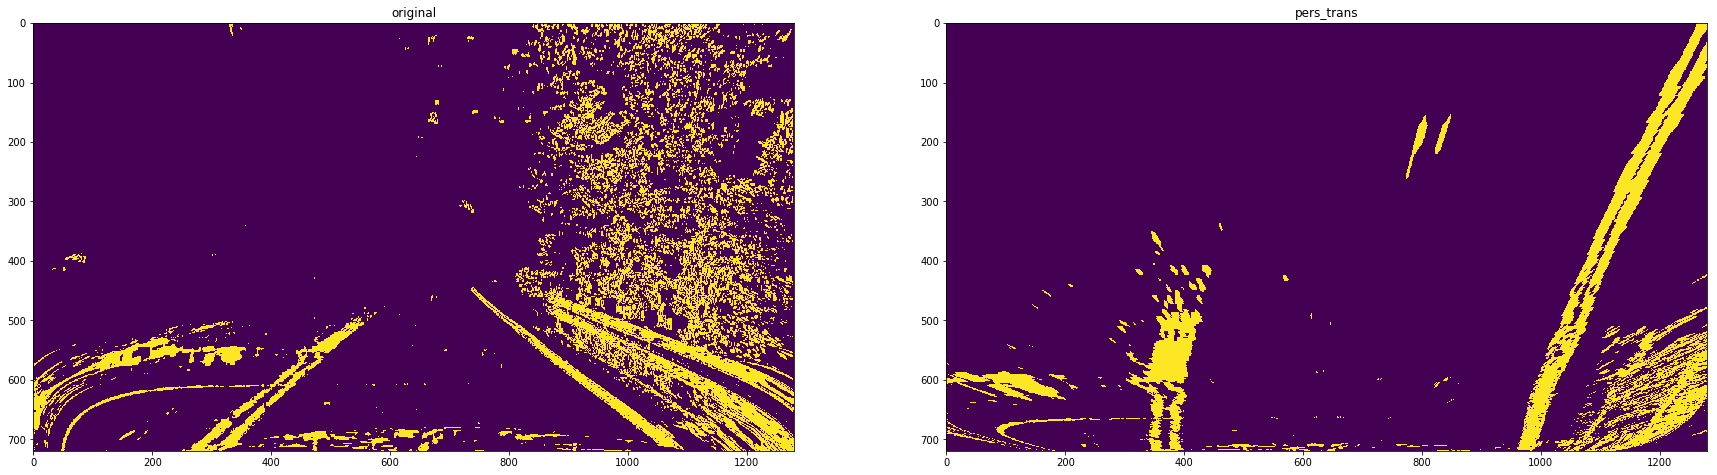

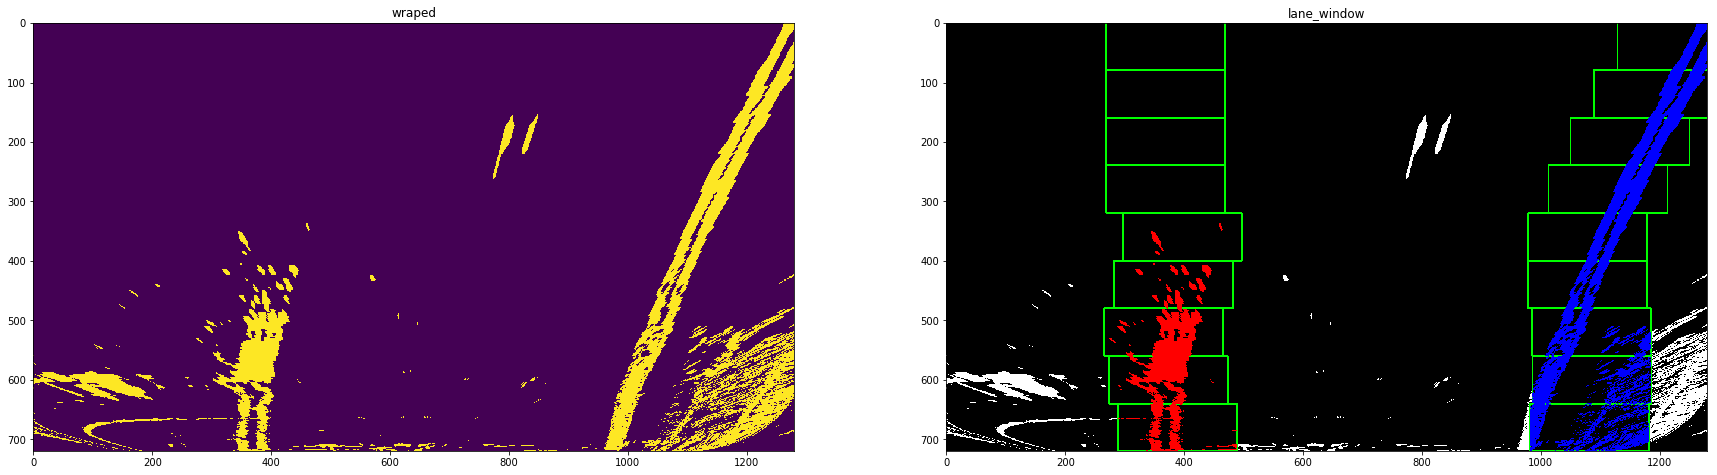

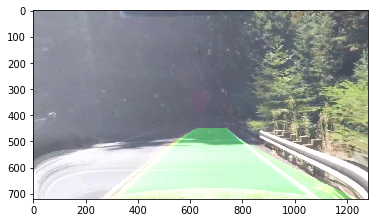

In [11]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_32.jpg'), plot=True))

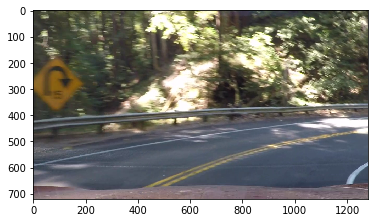

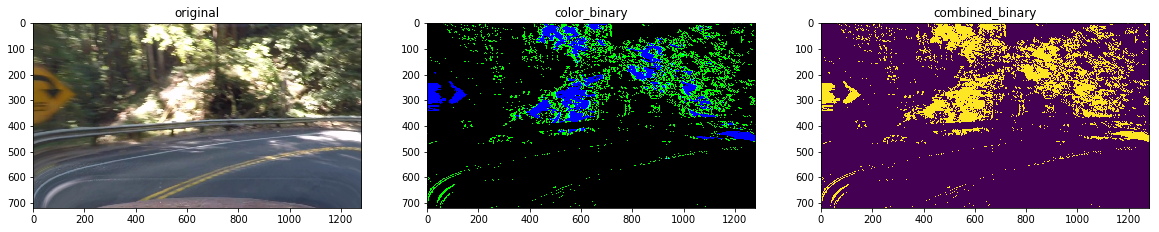

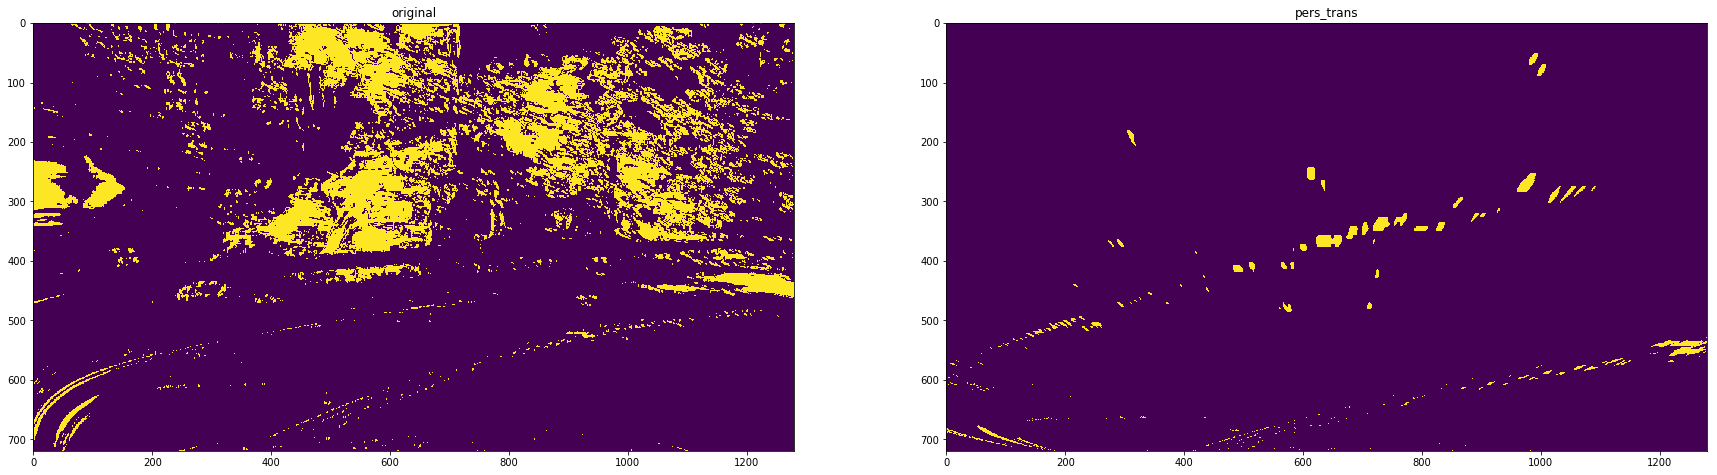

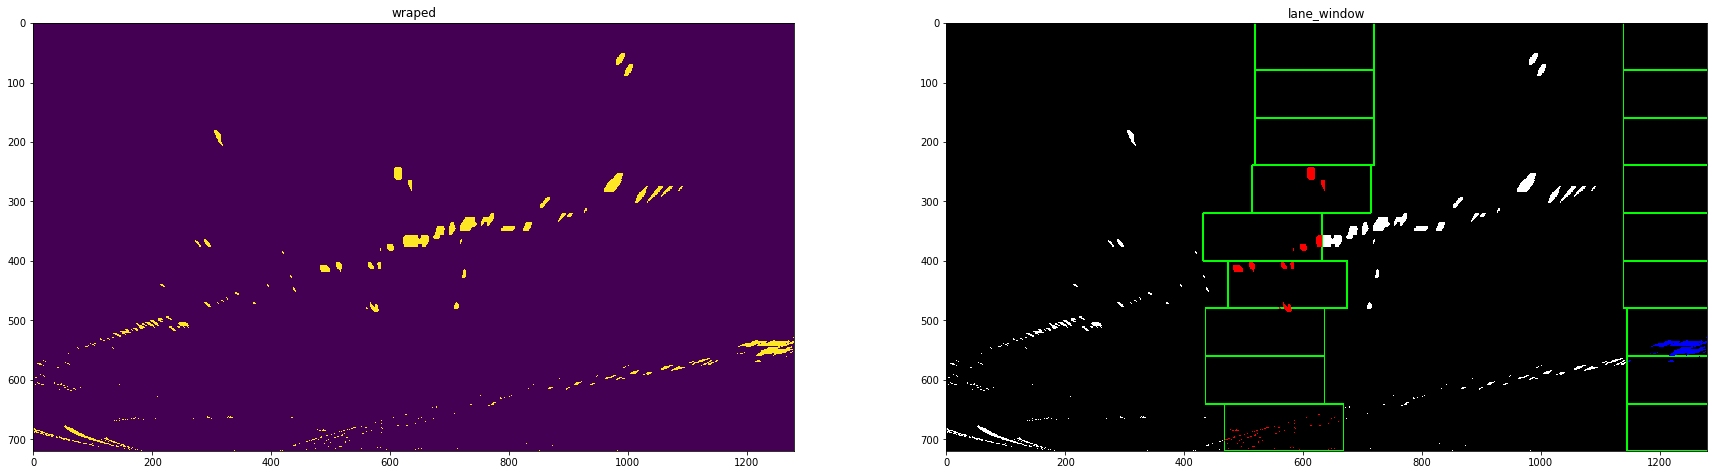

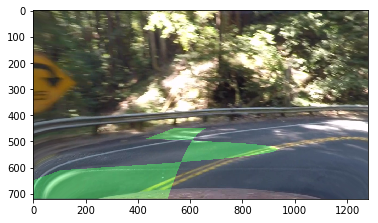

In [12]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_36.jpg'), plot=True))

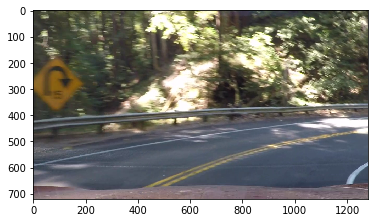

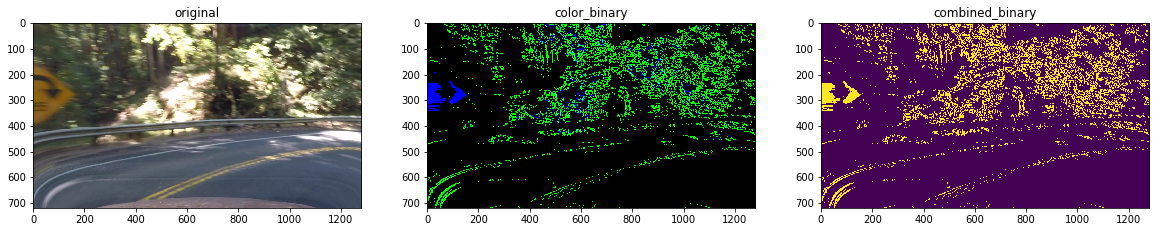

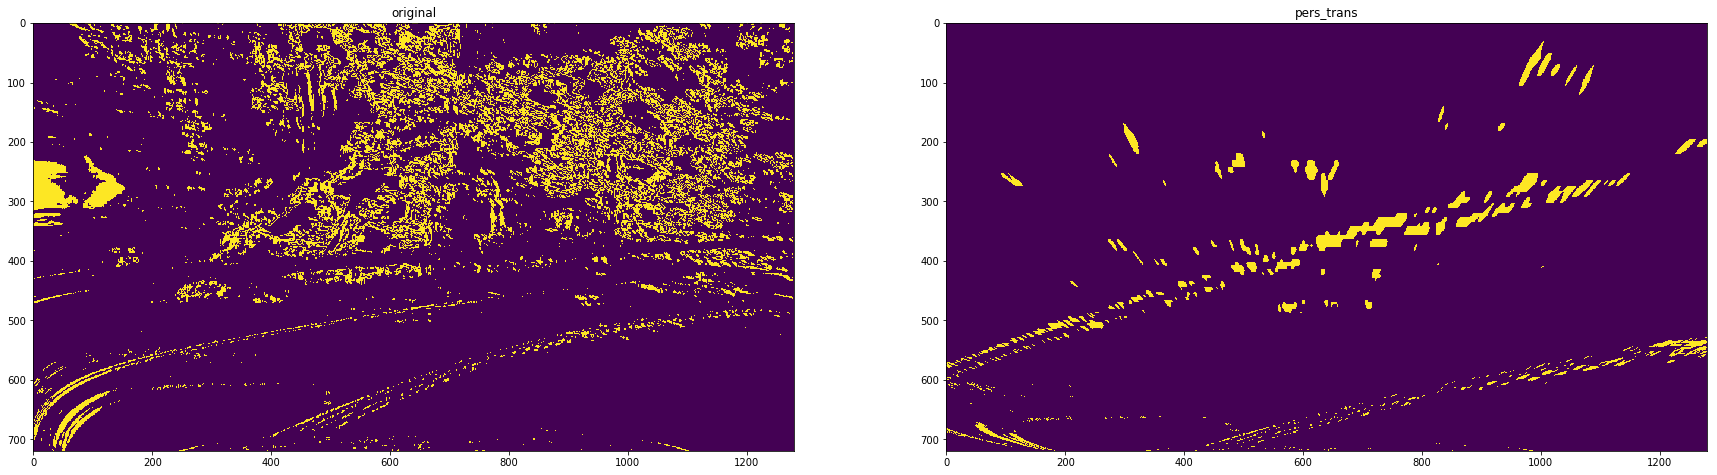

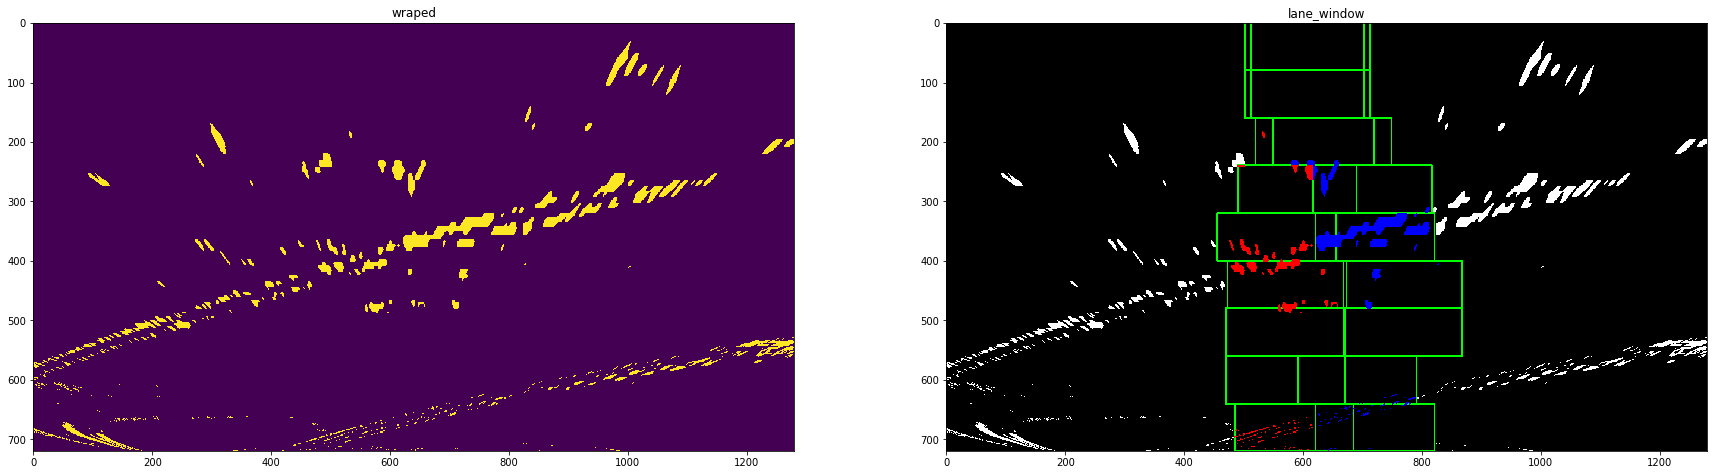

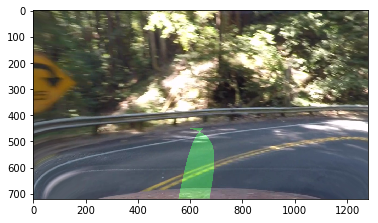

In [21]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_36.jpg'), plot=True, sx_thresh=(15, 50)))

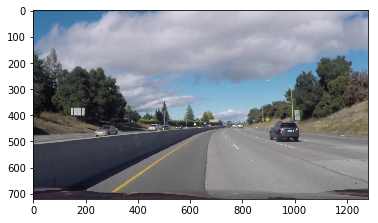

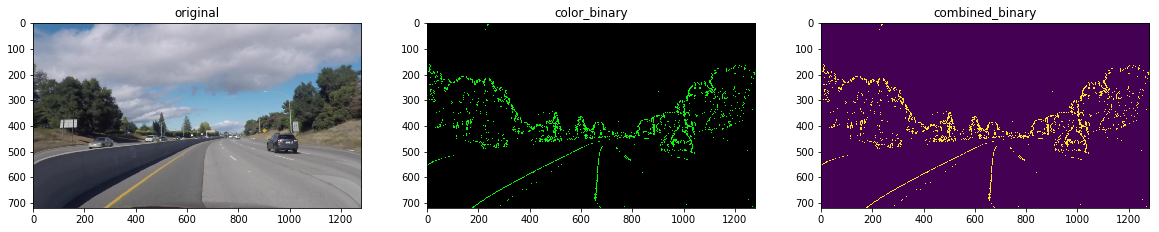

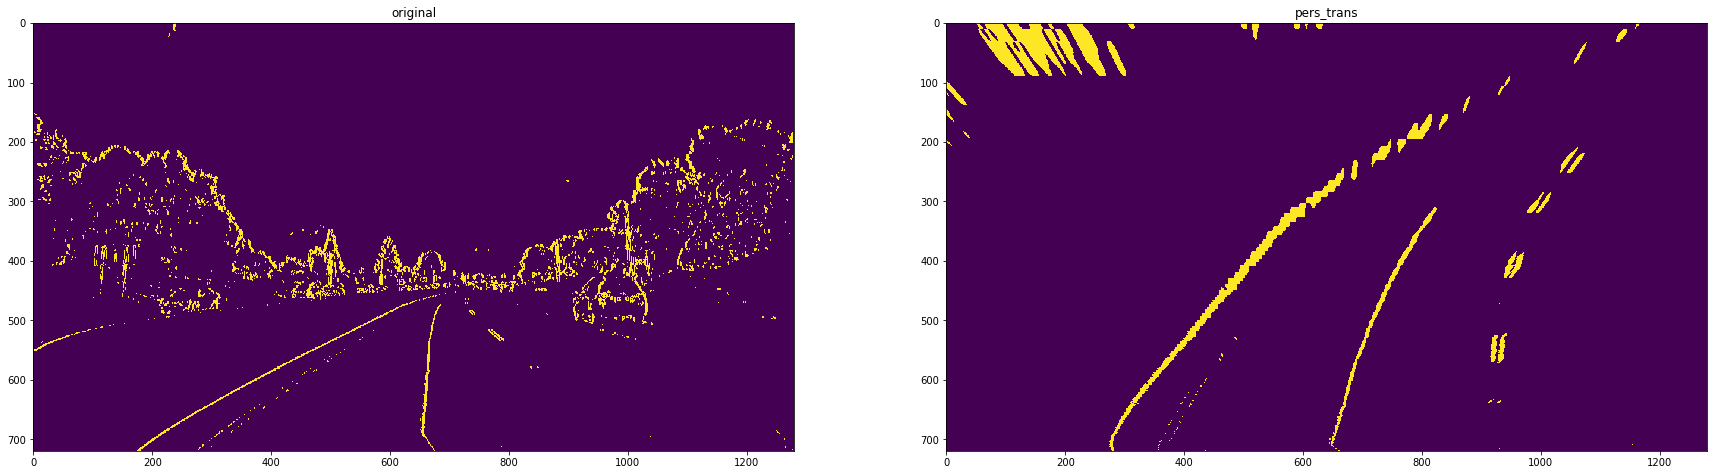

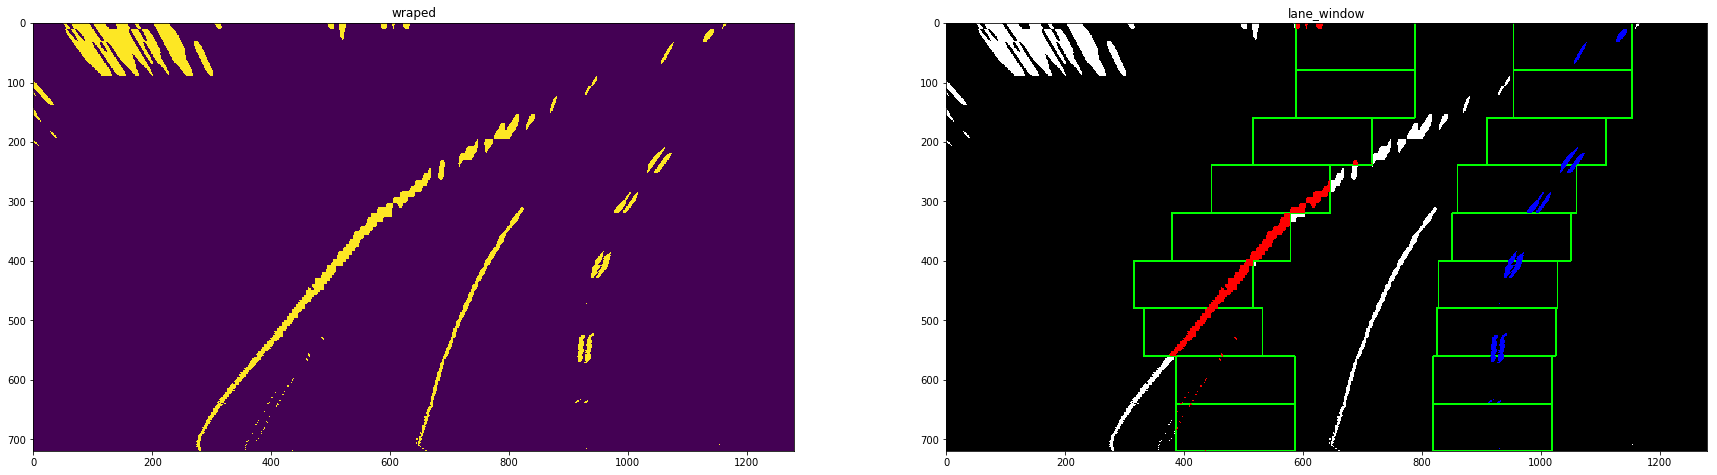

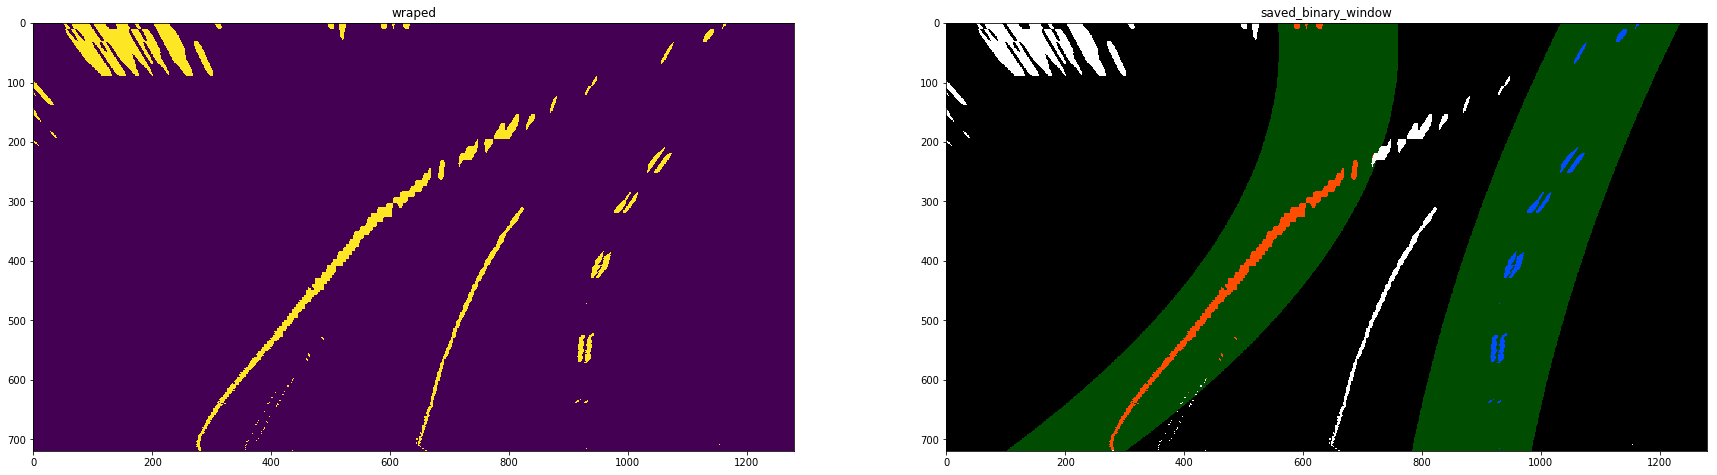

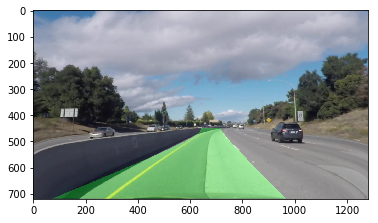

In [24]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_3.jpg'), plot=True))

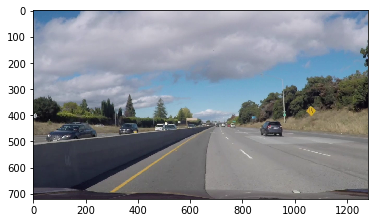

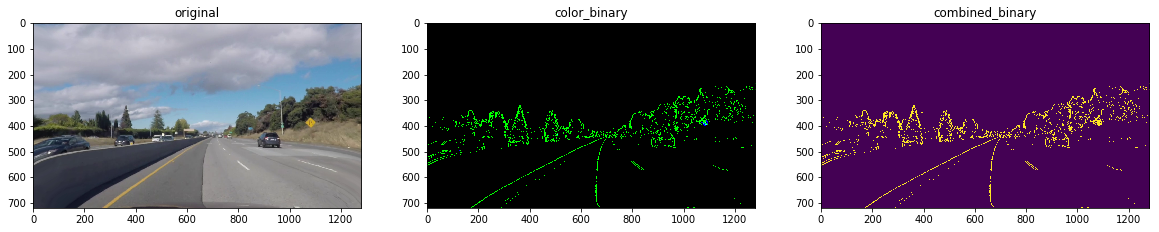

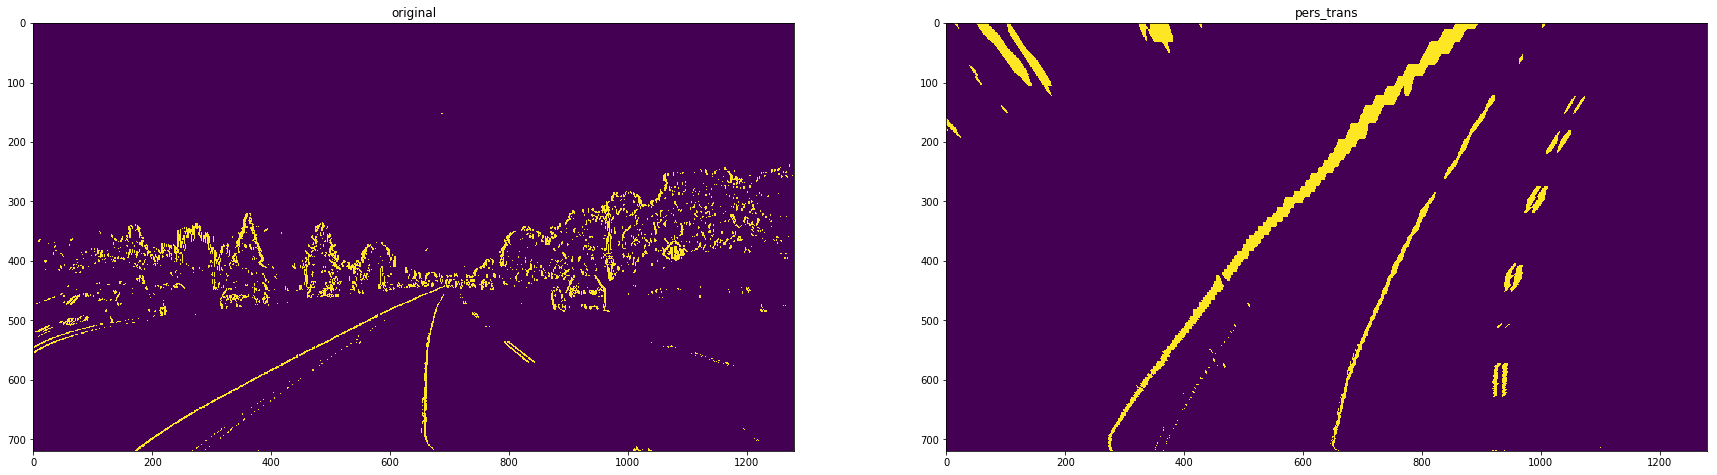

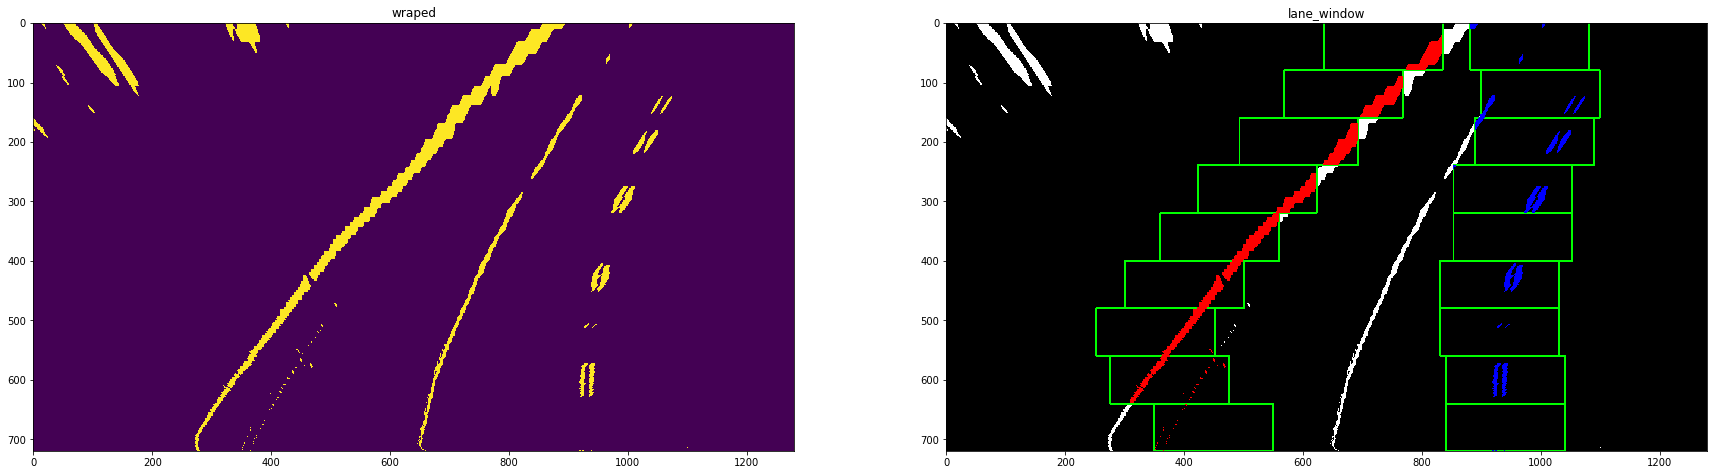

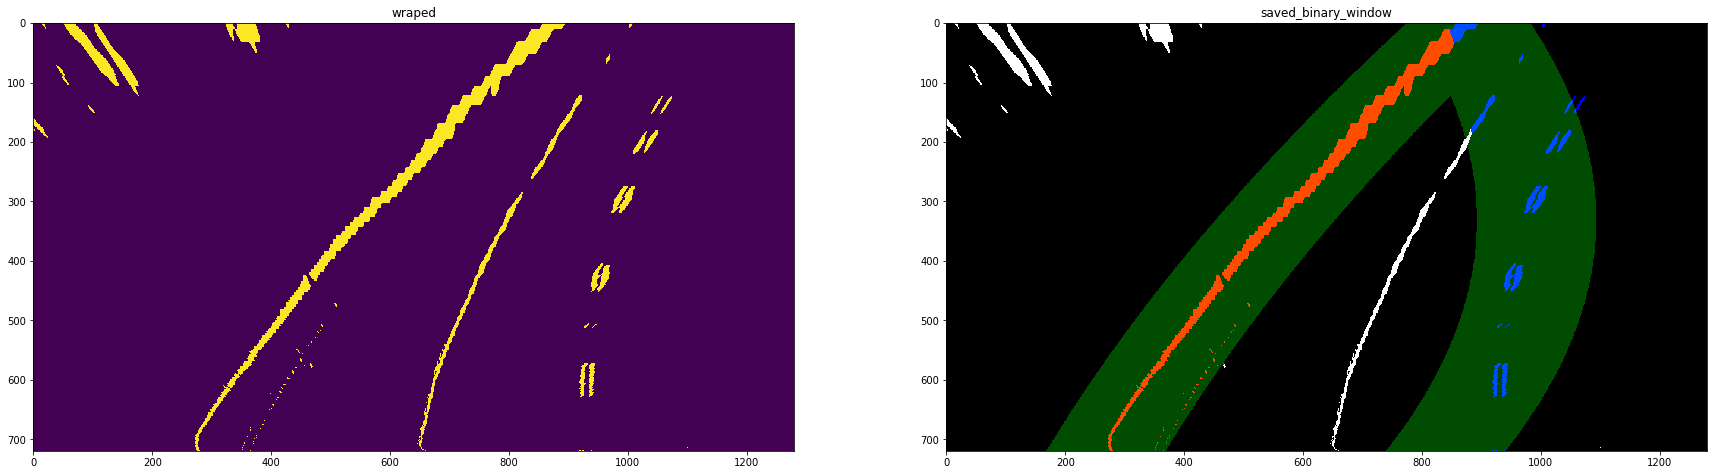

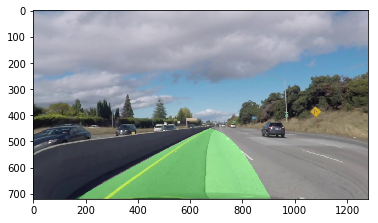

In [25]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_4.jpg'), plot=True))

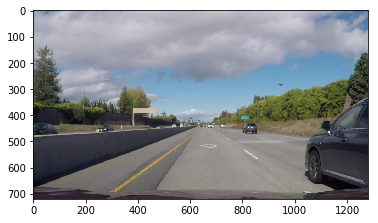

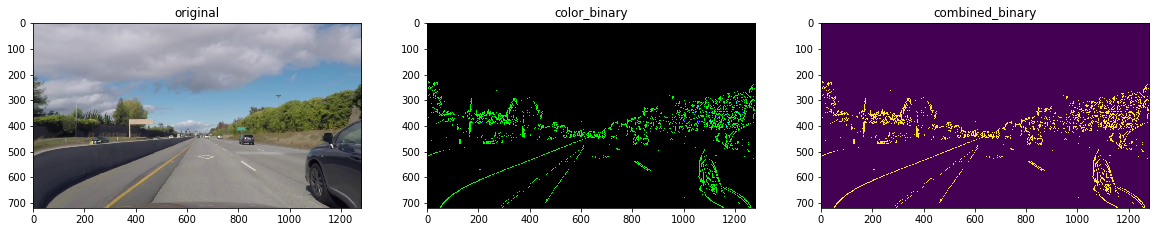

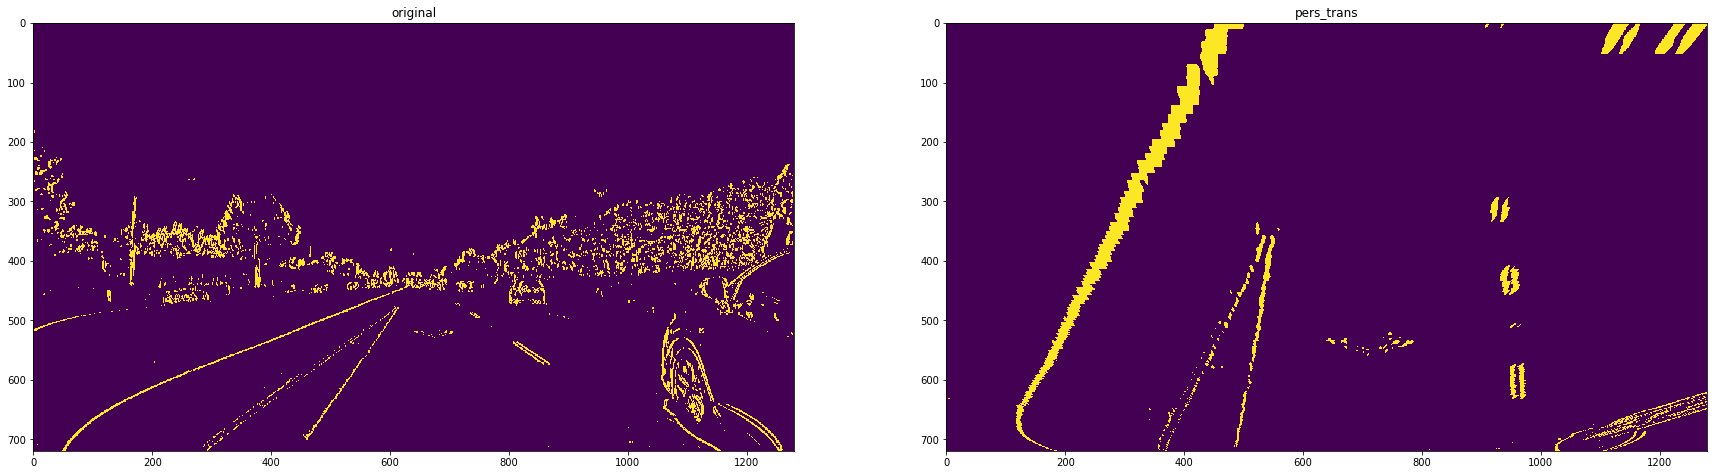

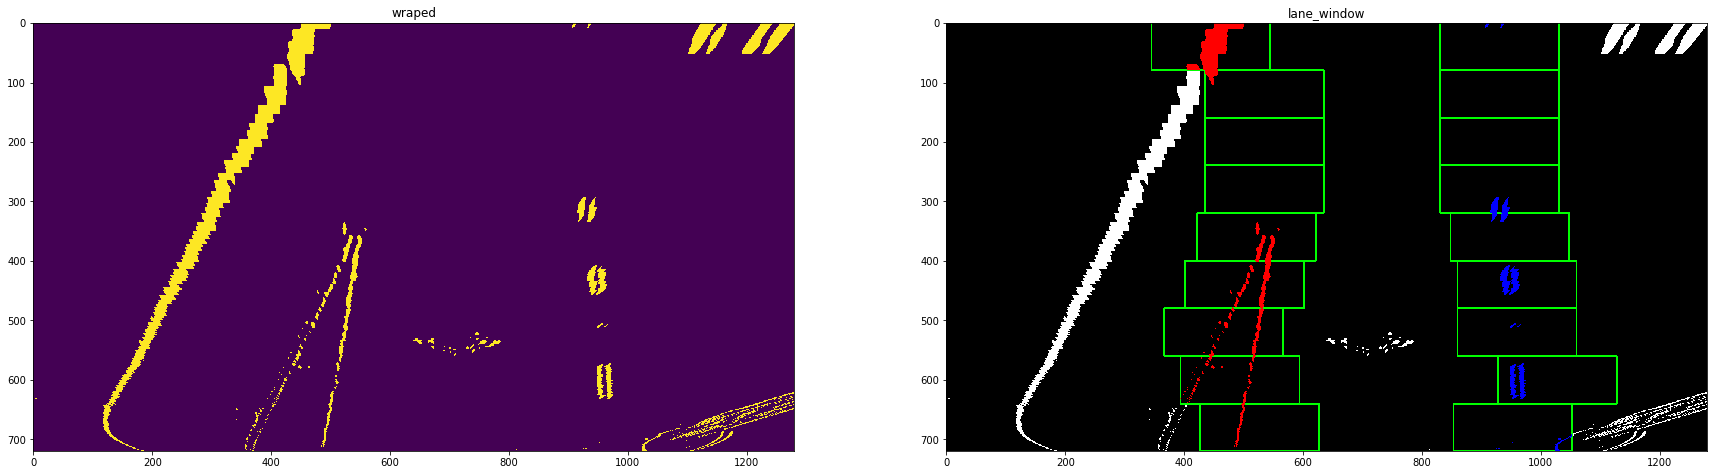

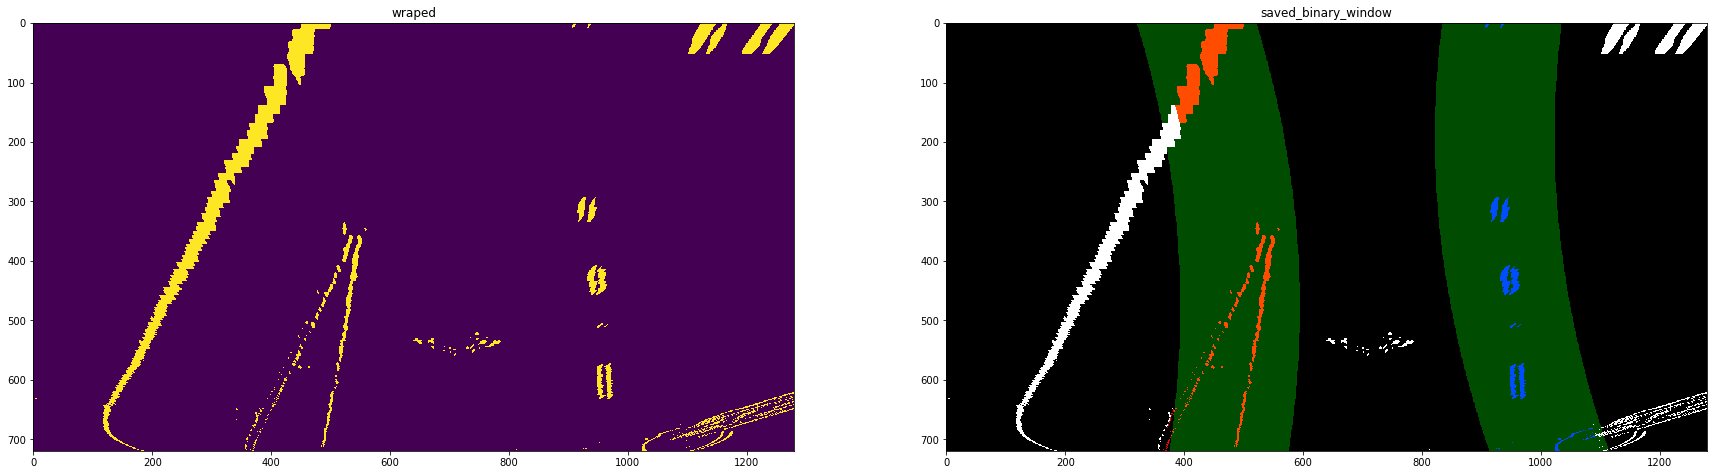

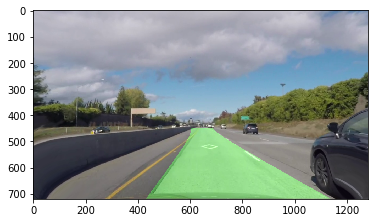

In [26]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_5.jpg'), plot=True))

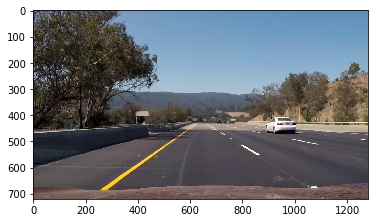

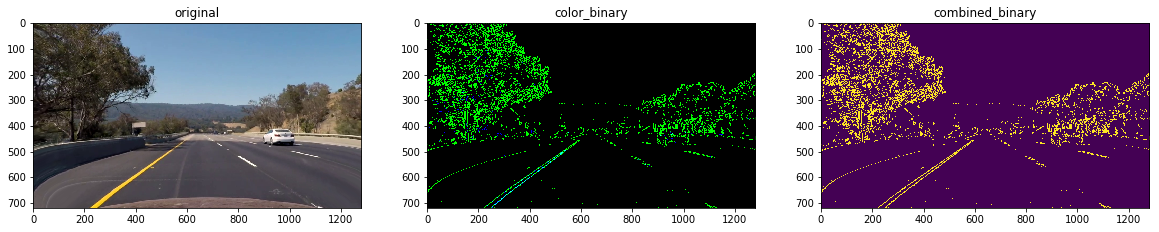

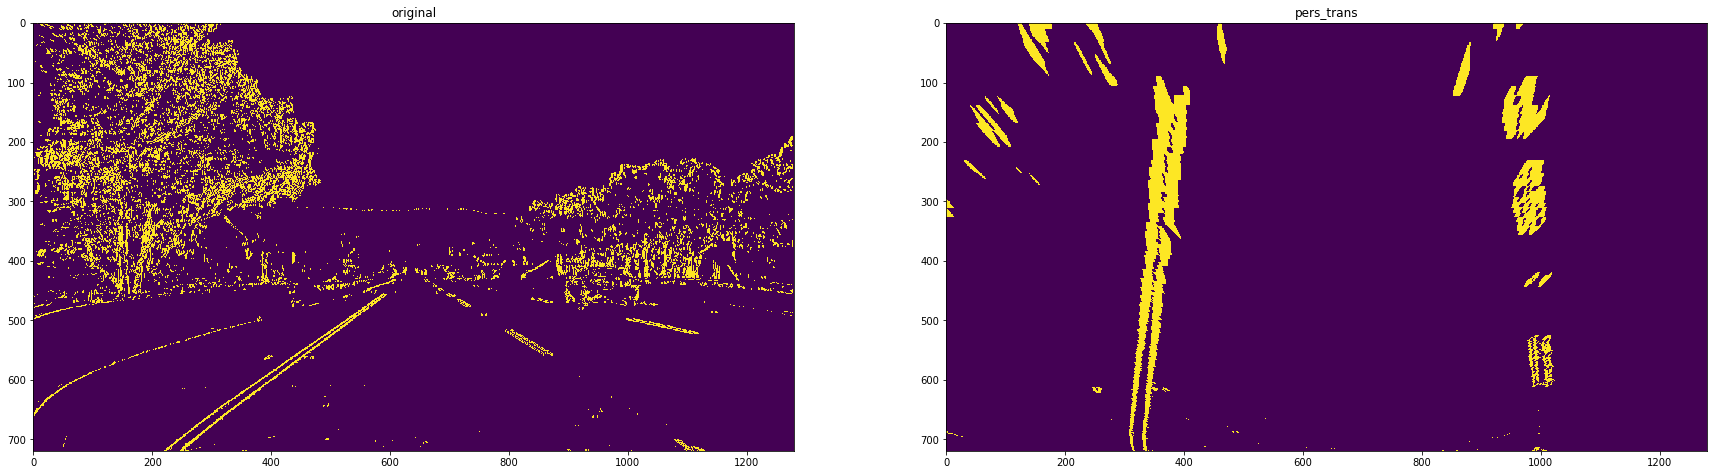

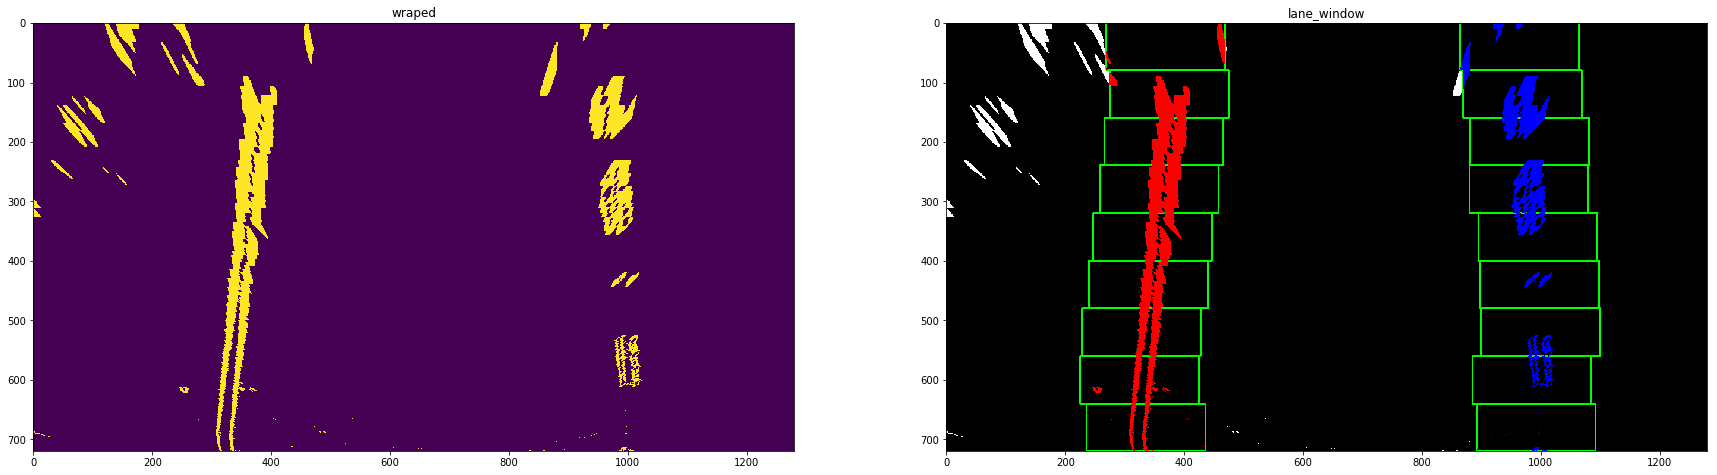

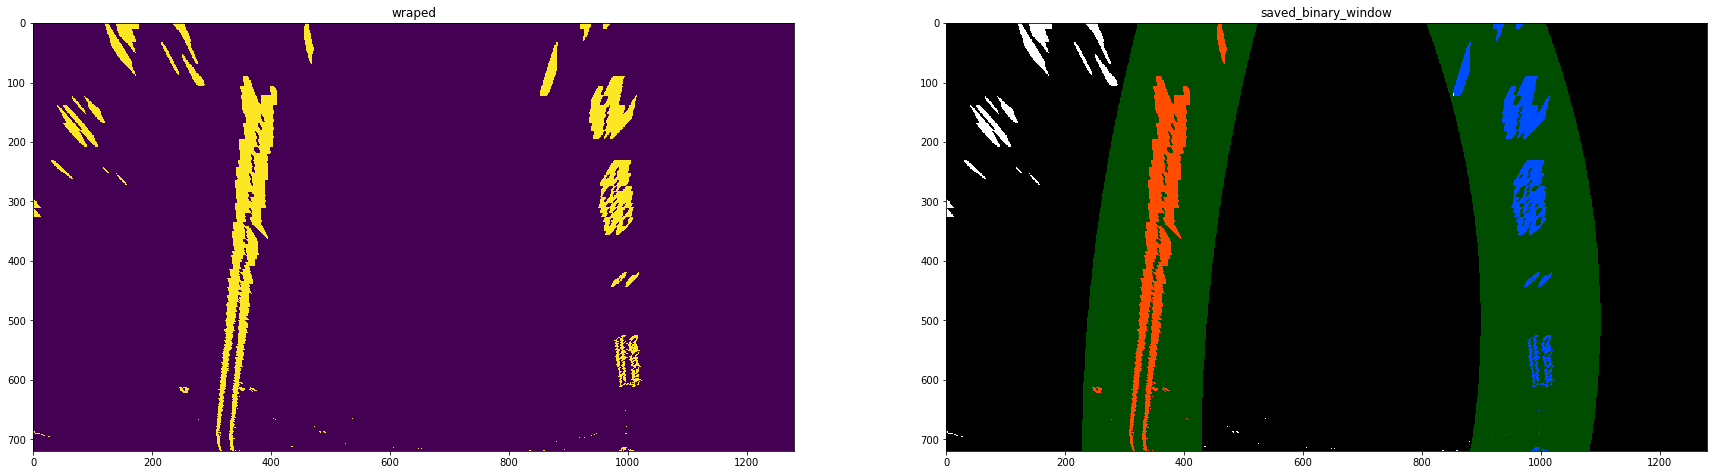

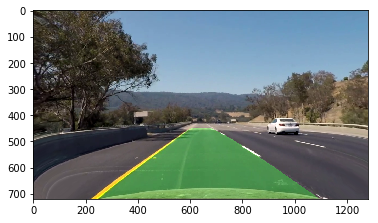

In [28]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_42.jpg'), plot=True))

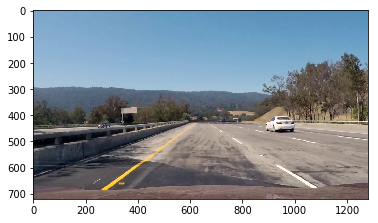

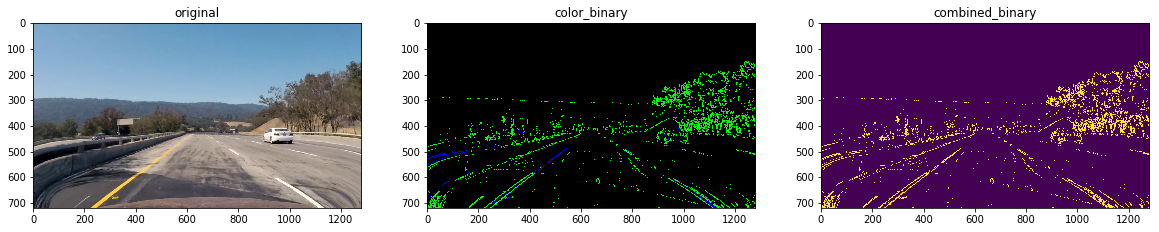

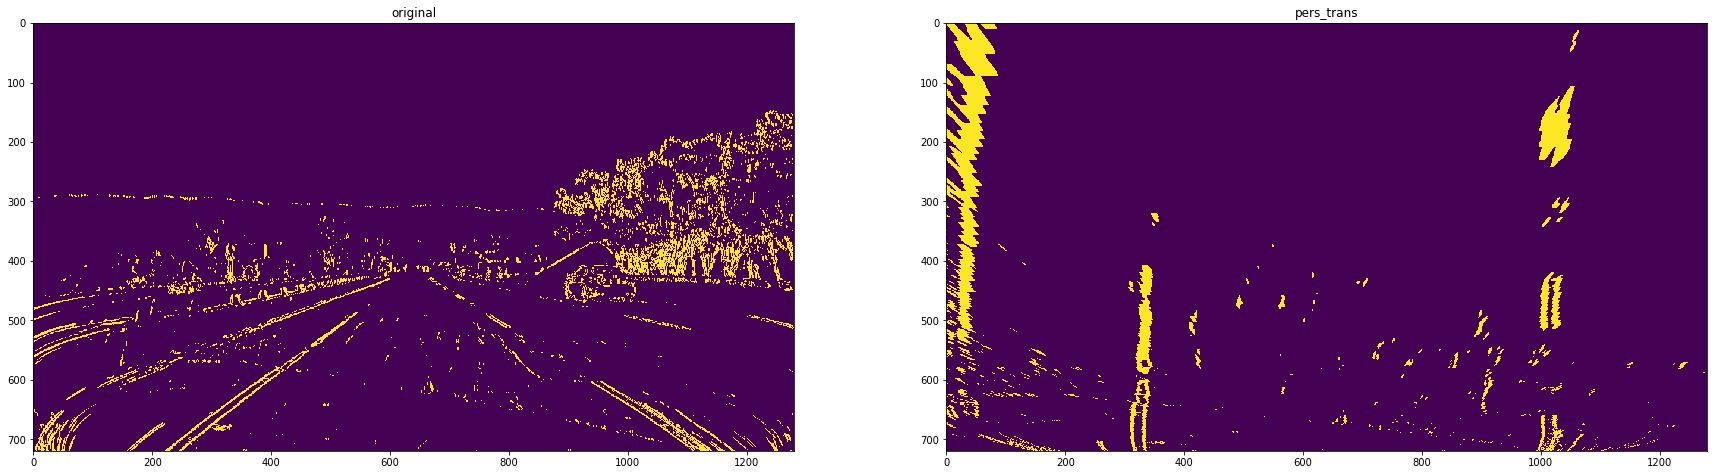

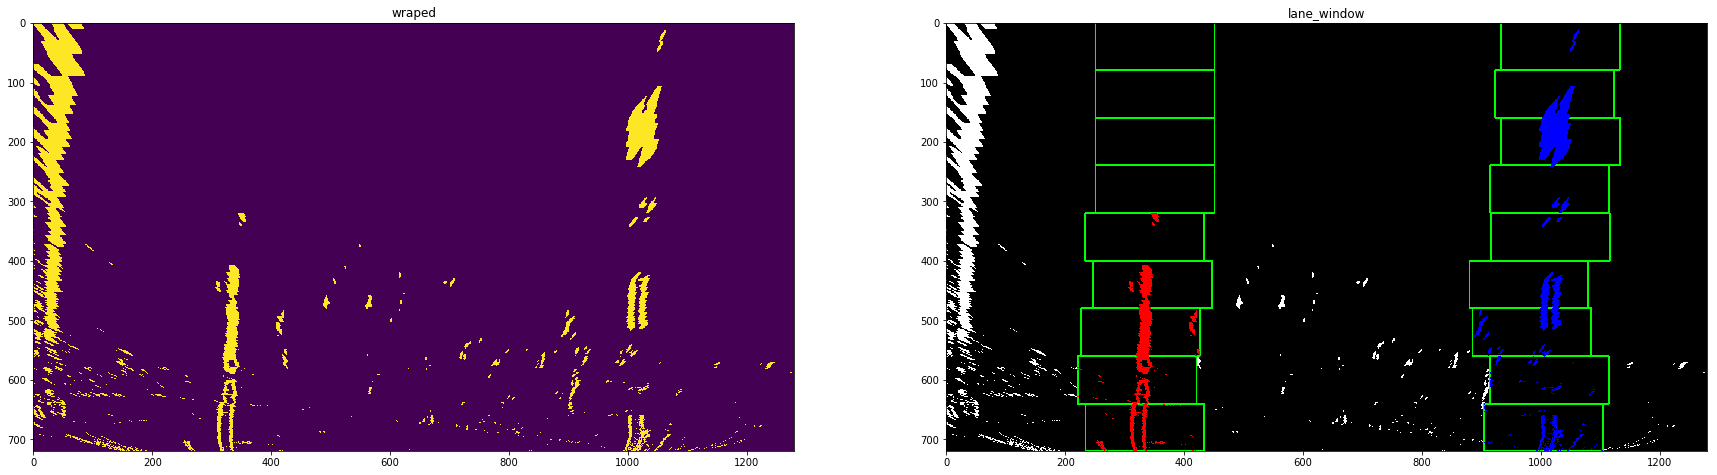

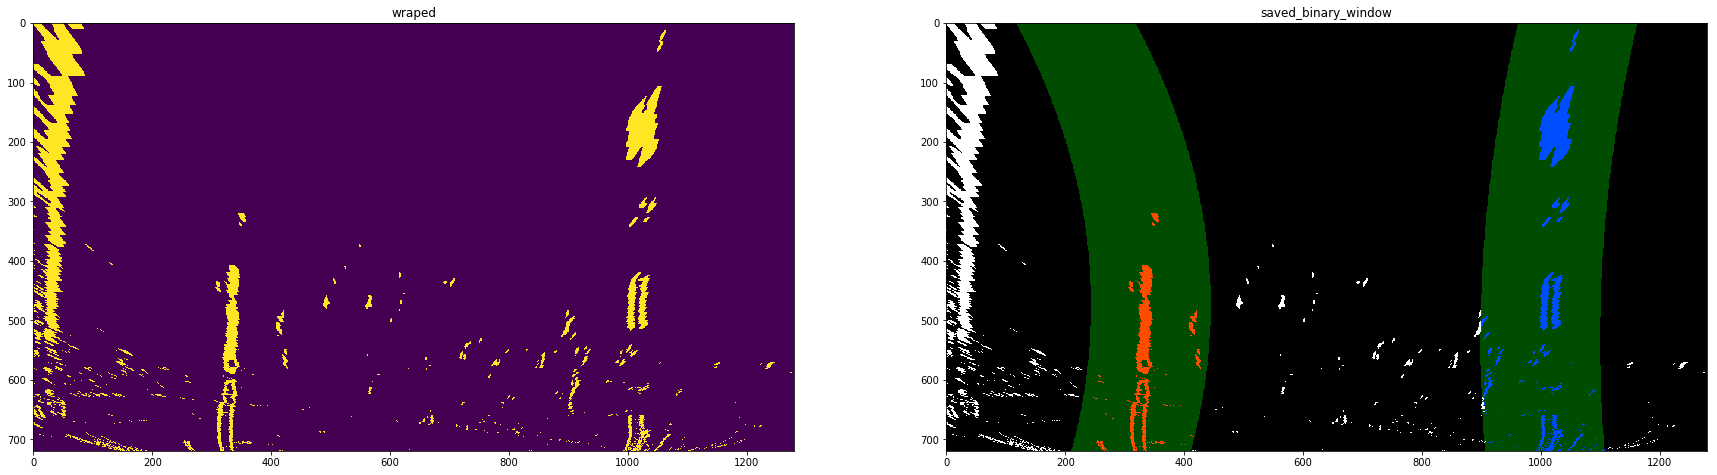

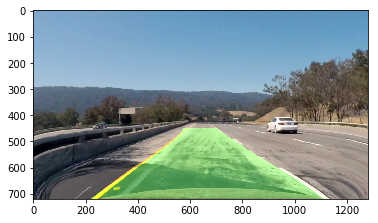

In [29]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_43.jpg'), plot=True))

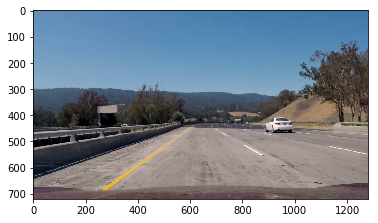

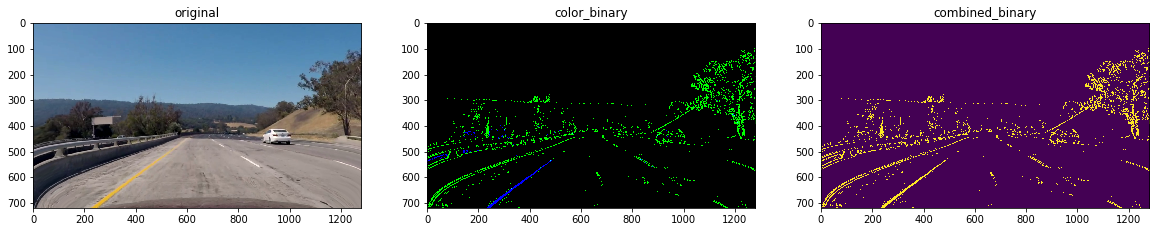

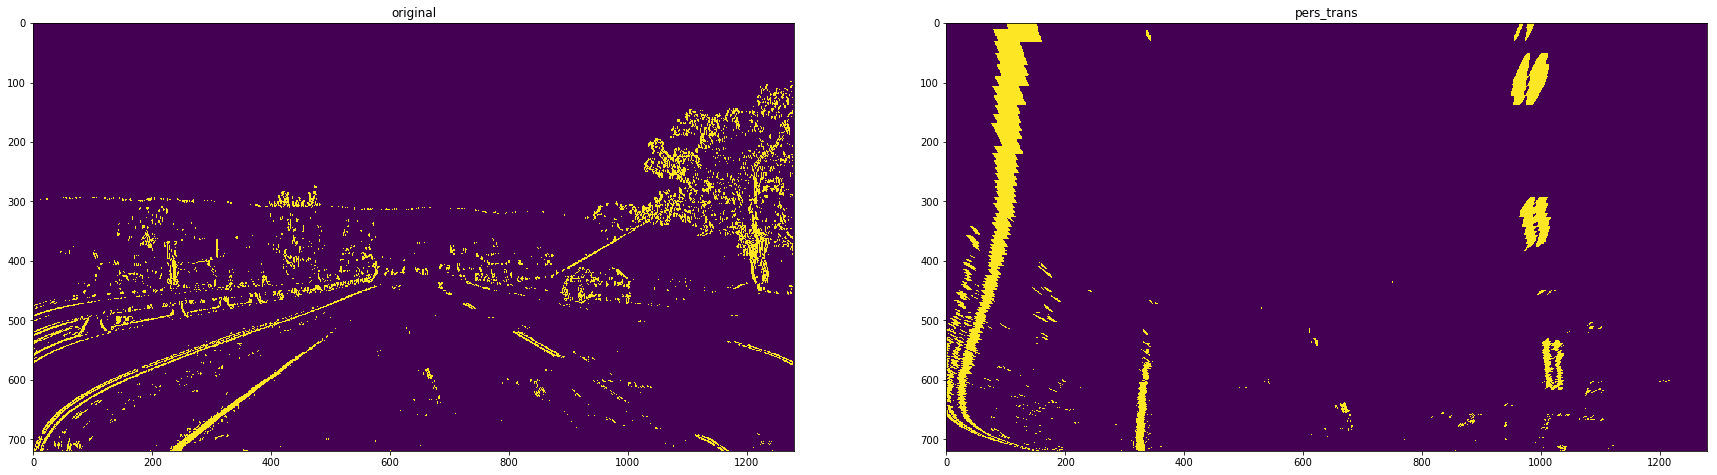

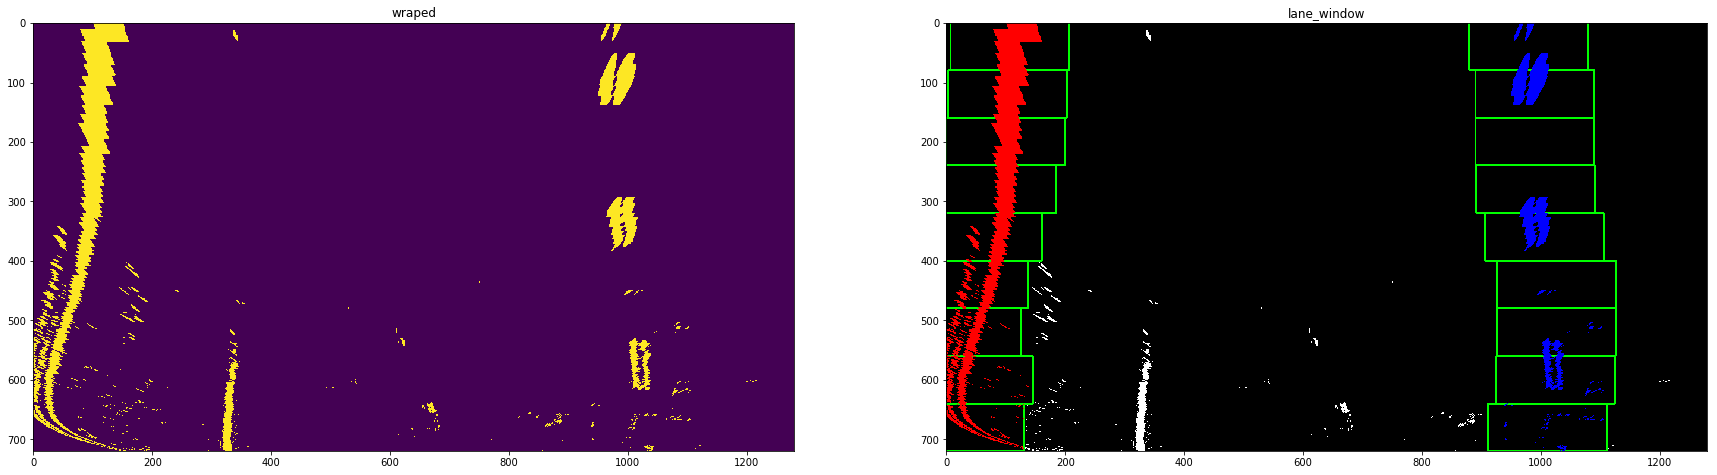

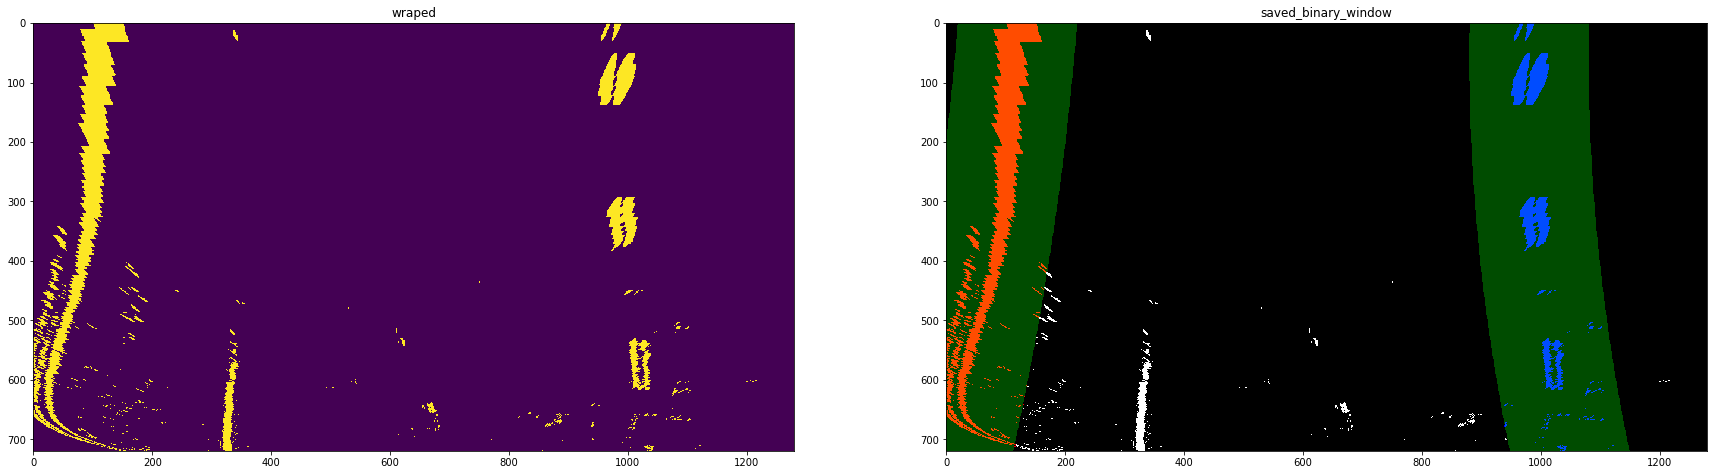

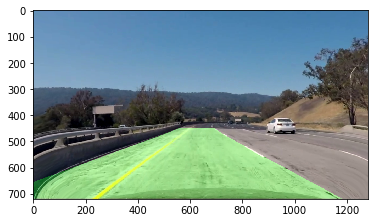

In [30]:
plt.imshow(pipeline(mpimg.imread('vlc/vlc_44.jpg'), plot=True))